In [1]:
# Synthetic Experiment for fairness 

# Load all necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import generate_data, generate_a_hat_indep_p, generate_y_hat, calc_assump_bounds, calculate_bias_metrics, calc_base_rates
from updated_balancers import BinaryBalancer
from tqdm import tqdm
sns.set_theme()

In [2]:
# Set the experiment
exp = 1

# Generate data
n = 10000
e1 = 1.5
e2 = 1.5
b = 0.05
group = 1
X, a, y  = generate_data(n,e1,e2,b,group,exp)

# Calculate base rates
r,s,v,w = calc_base_rates(y,a)
min_rate = min(r,s,v,w)
print('min rate = ', min_rate)

# Generate y_hat using random coefficients
k = 1000
mu_c = np.array([1,1,1])
var_c = np.array([[0.1,0,0],[0,0.1,0],[0,0,0.1]])

min rate =  0.2328


In [3]:
# Generate a_hat
p_errors = [0.10,0.20]
diff_bound_tpr = []
diff_bound_fpr = []

for p in p_errors:
    a_hat = generate_a_hat_indep_p(a,p)
    a_error = np.sum(a_hat != a)/a_hat.shape[0]
    k1 = calc_assump_bounds(r,s,a_error,0.025)
    k2 = calc_assump_bounds(v,w,a_error,0.025)
    bias_tpr_list = []
    bias_fpr_list = []
    u_bound_tpr = []
    u_bound_fpr = []
    # print('a_hat_error = ', a_error)
    i = 0

    while i < k:
        # Generate y_hat
        coeffs = np.random.multivariate_normal(mu_c,var_c,1).T
        y_prob, y_hat = generate_y_hat(X,coeffs,exp)

        # bias using true values of a
        balancer = BinaryBalancer(y=y, a=a, y_=y_hat)
        alpha, beta, tau, phi = calculate_bias_metrics(balancer)
        bias_tpr = np.abs(alpha - beta)
        if bias_tpr < 0.025:
            continue
        bias_tpr_list.append(bias_tpr)
        bias_fpr = np.abs(tau-phi)
        if bias_tpr < 0.025:
            continue
        bias_fpr_list.append(bias_fpr)

        # bias estimate using a_hat
        balancer_h = BinaryBalancer(y=y, a=a_hat, y_=y_hat)
        alpha_h, beta_h, tau_h , phi_h = calculate_bias_metrics(balancer_h)
        bias_est_tpr = np.abs(alpha_h - beta_h)
        bias_est_fpr = np.abs(tau_h - phi_h)
        # if k1*bias_est_tpr - bias_tpr < 0:
            # print(k1*bias_est_tpr - bias_tpr)
        # if k2*bias_est_fpr - bias_fpr < 0:
            # print(k2*bias_est_fpr - bias_fpr)

        # Computing the upper bound and lower bounds under the assumption
        u_bound_tpr.append(k1*bias_est_tpr)
        u_bound_fpr.append(k2*bias_est_fpr)
        i = i+1
        if i % 100 == 0:
            print(i)

    diff_tpr = np.array(u_bound_tpr) - np.array(bias_tpr_list)
    diff_fpr = np.array(u_bound_fpr) - np.array(bias_fpr_list)
    # To handle numbers like -0.000001
    diff_tpr[diff_tpr < 0] = 0
    diff_fpr[diff_fpr < 0] = 0
    diff_bound_tpr.append(diff_tpr)
    diff_bound_fpr.append(diff_fpr)

100
200
300
400
500
600
700
800
900
1000
100
200
300
400
500
600
700
800
900
1000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


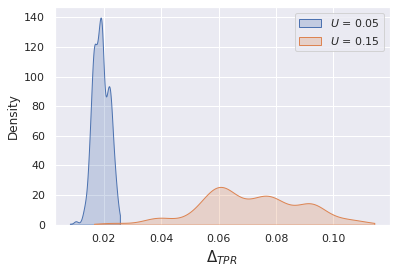

In [4]:
# Generate KDE Plots
sns.kdeplot(diff_bound_tpr[0], shade = True, label = r'$U$ = 0.05',cut = 0)
sns.kdeplot(diff_bound_tpr[1], shade = True, label = r'$U$ = 0.15',cut = 0)
# sns.kdeplot(diff_bound_tpr[2], shade = True, label = r'$U$ = 0.15',cut = 0)
# sns.kdeplot(diff_bound_tpr[3], shade = True, label = r'$U$ = 0.20',cut = 0)
plt.legend()
plt.xlabel(r'$\Delta_{TPR}$', fontsize=15)
plt.savefig('Figures/newExp1/assump_tpr_bound.eps',bbox_inches="tight")

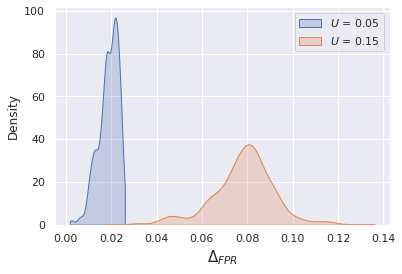

In [47]:
# Generate KDE Plots
sns.kdeplot(diff_bound_fpr[0], shade = True, label = r'$U$ = 0.05',cut = 0)
sns.kdeplot(diff_bound_fpr[1], shade = True, label = r'$U$ = 0.15',cut = 0)
# sns.kdeplot(diff_bound_fpr[2], shade = True, label = r'$U$ = 0.15',cut = 0)
# sns.kdeplot(diff_bound_fpr[3], shade = True, label = r'$U$ = 0.20',cut = 0)
plt.legend()
plt.xlabel(r'$\Delta_{FPR}$', fontsize=15)
plt.savefig('Figures/newExp1/assump_fpr_bound',bbox_inches="tight")